# Time Series Extraction

In [1]:
import xarray as xr
import cf_xarray
import extract_model as em
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# For this notebook, it's nicer if we don't show the array values by default
xr.set_options(display_expand_data=False)
xr.set_options(display_expand_coords=False)
xr.set_options(display_expand_attrs=False)


## Example model to use

In [2]:
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t12z.nc
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t18z.nc

In [3]:
# Structured: CIOFS: ROMS Cook Inlet model
# get some model output locally
# loc1 = glob('nos.ciofs.*.nc')
# ds1 = xr.open_mfdataset([loc1], drop_variables="ocean_time", preprocess=em.preprocess).sel(time=slice("2022-03-01T07", "2022-03-01T08"))
loc1 = "https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-agg/Aggregated_CIOFS_Fields_Forecast_best.ncd"
ds1 = xr.open_dataset(loc1, drop_variables="ocean_time")
ds1 = em.preprocess(ds1, kwargs={"interp_vertical": False})
ds1 = ds1.sel(time=slice("2022-03-01T07", "2022-03-01T08"))
ds1

# # Unstructured: CREOFS: SELFE Columbia River model
# today = pd.Timestamp.today()
# loc2 = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n000.%Y%m%d.t03z.nc'),
#         today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n001.%Y%m%d.t03z.nc')]


## Demo code

### Select time series from nearest point

Use a DataArray or a Dataset, but keep in mind that when there are multiple horizontal grids (like there are for ROMS models), you will need to specify which grid's longitude and latitude coordinates to use. The API is meant to be analogous to that of selecting with `xarray` using `.sel()`.

This functionality uses [`xoak`](https://xoak.readthedocs.io/en/latest/).

In [5]:
da1 = ds1['temp']
lon0, lat0 = -151.4, 59  # cook inlet

For any of the following results, access the depth values with

```
[output].cf['vertical'].values
```

#### 2D lon/lat

The first request will take longer than a second request would because the second request uses the index calculated the first time.

In [6]:
%%time
output = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
output

CPU times: user 608 ms, sys: 15.1 ms, total: 623 ms
Wall time: 624 ms


<xarray.DataArray 'temp' (time: 2, s_rho: 30)>
...
Coordinates: (7)
Attributes: (9)

In [7]:
%%time
output = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
output

CPU times: user 4.02 ms, sys: 1.92 ms, total: 5.95 ms
Wall time: 4.24 ms


<xarray.DataArray 'temp' (time: 2, s_rho: 30)>
...
Coordinates: (7)
Attributes: (9)

Access the associated indices:

In [8]:
j, i = int(output.eta_rho.values), int(output.xi_rho.values)

Profile for first time matches:

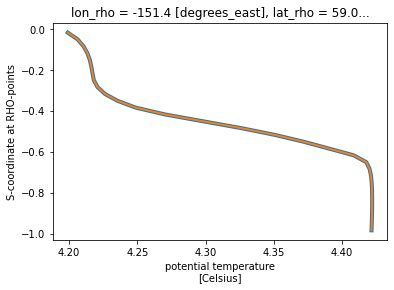

In [9]:
output.cf.isel(T=0).cf.plot(y='vertical', lw=4)
da1.cf.isel(X=i, Y=j, T=0).cf.plot(y='vertical', lw=2)

Surface value for first time matches map:

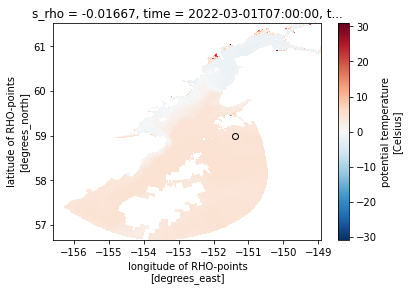

In [10]:
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude')
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=mappable.cmap, vmin=vmin, vmax=vmax, edgecolors='k')

To retrieve the values:

`output.values`

In [11]:
output.values

array([[4.4214993, 4.421684 , 4.4218173, 4.421909 , 4.4219575, 4.421951 ,
        4.4218597, 4.4216237, 4.421123 , 4.4200873, 4.4176564, 4.408428 ,
        4.3901873, 4.371695 , 4.350696 , 4.325884 , 4.297998 , 4.270254 ,
        4.248803 , 4.2355056, 4.226392 , 4.2209353, 4.218213 , 4.2172427,
        4.216388 , 4.2152452, 4.213435 , 4.2106075, 4.206378 , 4.199108 ],
       [4.434471 , 4.4342895, 4.4340544, 4.4337626, 4.4333944, 4.4329157,
        4.4322686, 4.4313636, 4.4300494, 4.428064 , 4.4249015, 4.4193425,
        4.4073486, 4.377332 , 4.3381915, 4.306614 , 4.281716 , 4.261284 ,
        4.2448688, 4.2351127, 4.2280526, 4.222328 , 4.2180495, 4.216049 ,
        4.214684 , 4.2133946, 4.2117043, 4.209222 , 4.2054753, 4.1987357]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [12]:
output.cf['vertical'].values

array([-0.98333333, -0.95      , -0.91666667, -0.88333333, -0.85      ,
       -0.81666667, -0.78333333, -0.75      , -0.71666667, -0.68333333,
       -0.65      , -0.61666667, -0.58333333, -0.55      , -0.51666667,
       -0.48333333, -0.45      , -0.41666667, -0.38333333, -0.35      ,
       -0.31666667, -0.28333333, -0.25      , -0.21666667, -0.18333333,
       -0.15      , -0.11666667, -0.08333333, -0.05      , -0.01666667])

#### 3D lon/lat/Z or iZ

Return model output nearest to lon, lat, Z value. `z_rho` has two values because the depth changes in time.

In [13]:
out = da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).squeeze()
out

<xarray.DataArray 'temp' (time: 2, s_rho: 30)>
...
Coordinates: (7)
Attributes: (9)

In [14]:
out.em.selZ(depths=-40)

<xarray.DataArray 'temp' (time: 2)>
4.421 4.434
Coordinates: (7)
Attributes: (9)

Return model output nearest to lon, lat, at index iZ in Z dimension.

In [15]:
da1.em.sel2d(lon_rho=lon0, lat_rho=lat0).cf.isel(Z=-1)

<xarray.DataArray 'temp' (time: 2, loc: 1)>
...
Coordinates: (7)
Dimensions without coordinates: loc
Attributes: (9)

### Interpolate time series at exact point

In [16]:
da1 = ds1['salt']
lon0, lat0 = -152, 58
lons, lats = [-151, -152], [59,58]

#### 2D lon/lat

1 lon/lat pair

In [17]:
%%time
output = da1.em.interp2d(lon0, lat0)
output

CPU times: user 8.95 s, sys: 2.08 s, total: 11 s
Wall time: 30.1 s


<xarray.DataArray 'salt' (time: 2, s_rho: 30)>
32.94 32.94 32.94 32.94 32.94 32.94 ... 32.87 32.87 32.87 32.87 32.87 32.87
Coordinates: (5)
Attributes: (8)

Surface value for first time matches map:

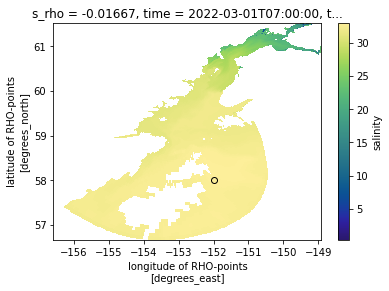

In [18]:
cmap=cmo.haline
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude', cmap=cmap)
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='k')

To retrieve the values:

`output.values`

In [19]:
output.values

array([[32.93971 , 32.939648, 32.939594, 32.93954 , 32.939472, 32.939392,
        32.939293, 32.93917 , 32.93898 , 32.93863 , 32.937885, 32.936424,
        32.933247, 32.92608 , 32.918026, 32.910328, 32.903812, 32.898037,
        32.892227, 32.88485 , 32.877373, 32.875435, 32.875843, 32.87596 ,
        32.875977, 32.875988, 32.875996, 32.875996, 32.87599 , 32.875977],
       [32.938396, 32.93832 , 32.938255, 32.93819 , 32.938118, 32.93803 ,
        32.93791 , 32.93775 , 32.937523, 32.937138, 32.9364  , 32.934933,
        32.931953, 32.92531 , 32.917496, 32.90954 , 32.90272 , 32.896683,
        32.89059 , 32.882954, 32.8751  , 32.87288 , 32.87316 , 32.873245,
        32.873253, 32.873257, 32.873257, 32.873253, 32.873245, 32.873226]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [20]:
output.cf['vertical'].values

array([-0.98333333, -0.95      , -0.91666667, -0.88333333, -0.85      ,
       -0.81666667, -0.78333333, -0.75      , -0.71666667, -0.68333333,
       -0.65      , -0.61666667, -0.58333333, -0.55      , -0.51666667,
       -0.48333333, -0.45      , -0.41666667, -0.38333333, -0.35      ,
       -0.31666667, -0.28333333, -0.25      , -0.21666667, -0.18333333,
       -0.15      , -0.11666667, -0.08333333, -0.05      , -0.01666667])

multiple lon/lat pairs

In [21]:
%%time
da1.em.interp2d(lons, lats)

CPU times: user 8.4 s, sys: 1.72 s, total: 10.1 s
Wall time: 27.6 s


<xarray.DataArray 'salt' (time: 2, s_rho: 30, lat: 2, lon: 2)>
32.49 32.05 32.95 32.94 32.49 32.05 ... 32.78 32.87 31.97 32.03 32.78 32.87
Coordinates: (5)
Attributes: (8)

#### 3D: lon, lat, iZ

Return model output interpolated to lon, lat, Z value.

In [22]:
da1.em.interp2d(lon0, lat0, Z=-40)

<xarray.DataArray 'salt' (time: 2)>
nan nan
Coordinates: (5)
Attributes: (8)

Return model output interpolated to lon, lat, at index iZ in Z dimension.

In [23]:
da1.em.interp2d(lon0, lat0, iZ=-1)

<xarray.DataArray 'salt' (time: 2)>
32.88 32.87
Coordinates: (5)
Attributes: (8)

Note that it is not currently possible to interpolate in depth when there are both multiple times and locations.

If uncommented, the following cell will return:
> NotImplementedError: Currently it is not possible to interpolate in depth with more than 1 other (time) dimension.

In [24]:
# da1.em.interp2d(lons, lats, Z=-40)